In [2]:
%reload_ext autoreload
#!pip install -r requirements.txt

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
600
torch.Size([100, 3])


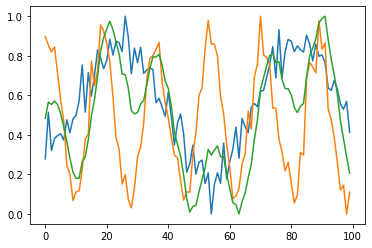

In [3]:
%autoreload
from architectures.RGAN import RGAN
from utils import *
from trainers import *
import numpy as np
np.random.seed(42)
alpha = 0.7
noise = 0.2

trainset = DatasetSinus(num=600, seq_len=100, alpha=alpha, noise=noise)
testset = DatasetSinus(num=600, seq_len=100, alpha=alpha, noise=noise)
#stocks_data = google_data_loading(100)

#trainset =DatasetStocks(stocks_data[:-300])
#testset =DatasetStocks(stocks_data[-300:])
print(len(testset))
print(testset[0][0].size())
import matplotlib.pyplot as plt
plt.plot(trainset[1][0]);


In [ ]:
%autoreload
from architectures.RGAN import RGAN
import neptune.new as neptune
import torch

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="rgan",
    tags=["rgan", "instance noise"],
    description="RGAN",
    source_files=["rgan.py"],
    capture_hardware_metrics=True,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_rgan.pt",
    "n_epochs": 3000,
    "l_rate": 0.0001,
    "batch_size": 16,
    "num_layers": 2,
    "hidden_dim": 30,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "padding_value": 0.,
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params
run["dataset"] = {"alpha":alpha, "noise":noise}


model = RGAN(params)

rgan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                model_name=params["model_name"]
                )
# Generate random synthetic data
gen_z = rgan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-232
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Training


Epoch: 62, G: 0.6944, D: 1.3402:   2%|▏         | 63/3000 [03:11<2:33:25,  3.13s/it]

In [ ]:
plt.plot(gen_z[2]);

In [ ]:
def create_sin3(sin1, sin2, temporal=False):
    sin1, sin2 = np.array(sin1), np.array(sin2)
    e = 0.7  # temporal information weight
    seq_len = len(sin1)
    importance = np.array([e ** i for i in range(seq_len)])

    if temporal:
        sin3 = []
        for i in range(1, seq_len + 1):
            sin3.append(((importance[:i][::-1] * sin1[:i] + importance[:i][::-1] * sin2[:i]) / 2).sum())
        return sin3
    else:
        return [(s1 + s2) / 2 for s1, s2 in zip(sin1, sin2)]

In [ ]:
sample = 6
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()